In [30]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Nadam

In [14]:
# Load dataset
with open('dataset.json') as file:
    data = json.load(file)

In [15]:
# Initialize lists
sentences = []
labels = []

In [16]:
# Extract patterns and tags
for intent in data['intents']:
    for pattern in intent['patterns']:
        sentences.append(pattern)
        labels.append(intent['tag'])

In [17]:
# Tokenization
tokenizer = Tokenizer(num_words=2000, lower=True, oov_token='OOV')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding='post')

In [18]:
# Encoding labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

In [21]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, integer_encoded, test_size=0.3, random_state=42)

In [42]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=padded_sequences.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(len(set(labels)), activation='softmax', kernel_regularizer=l2(0.01)))

In [43]:
optimizer = Nadam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [44]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_chatbot_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [45]:
# Train model with validation and callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 8.9735 - accuracy: 0.0444
Epoch 1: val_accuracy improved from -inf to 0.06897, saving model to best_chatbot_model.keras
9/9 [==============================] - 18s 280ms/step - loss: 8.9735 - accuracy: 0.0444 - val_loss: 8.1895 - val_accuracy: 0.0690
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 8.1622 - accuracy: 0.0593
Epoch 2: val_accuracy did not improve from 0.06897
9/9 [==============================] - 1s 98ms/step - loss: 8.1622 - accuracy: 0.0593 - val_loss: 7.5586 - val_accuracy: 0.0690
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 7.4047 - accuracy: 0.0333
Epoch 3: val_accuracy did not improve from 0.06897
9/9 [==============================] - 1s 104ms/step - loss: 7.4047 - accuracy: 0.0333 - val_loss: 6.9904 - val_accuracy: 0.0690
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 6.5738 - accuracy: 0.1111
Epoch 4: val_accuracy did not improve from 0.

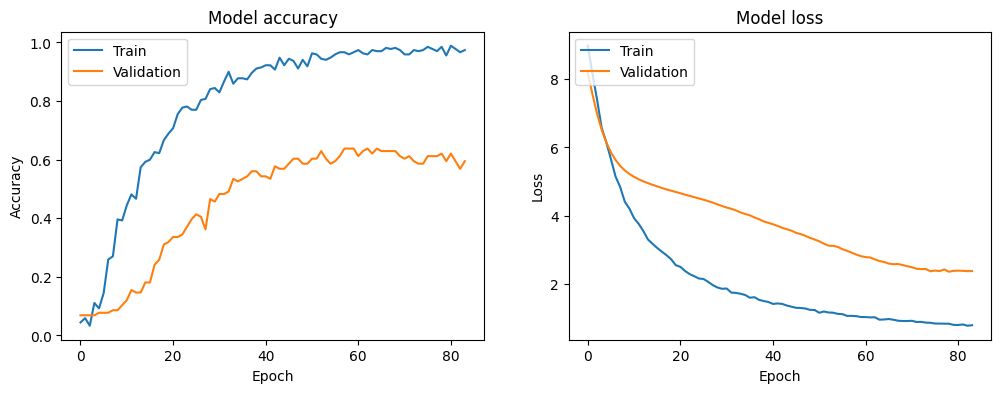

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [47]:
# Save the model with a different name to avoid conflicts
model.save('chatbot_model.h5')

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
